<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_EfficientNet_B0_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 12 17:42:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.205683002000001
GPU (s):
0.07215655100000617
GPU speedup over CPU: 72x


In [3]:
from google.colab import drive
import os
import glob
import pandas as pd

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp /content/drive/MyDrive/galaxy-images/img_RGB.zip /content/img_RGB.zip

In [6]:
!unzip /content/img_RGB.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/img_RGB/spiral/598869.jpg  
  inflating: content/img_RGB/spiral/111799.jpg  
  inflating: content/img_RGB/spiral/780317.jpg  
  inflating: content/img_RGB/spiral/910544.jpg  
  inflating: content/img_RGB/spiral/834411.jpg  
  inflating: content/img_RGB/spiral/733208.jpg  
  inflating: content/img_RGB/spiral/886610.jpg  
  inflating: content/img_RGB/spiral/911110.jpg  
  inflating: content/img_RGB/spiral/708993.jpg  
  inflating: content/img_RGB/spiral/412282.jpg  
  inflating: content/img_RGB/spiral/329964.jpg  
  inflating: content/img_RGB/spiral/550580.jpg  
  inflating: content/img_RGB/spiral/481037.jpg  
  inflating: content/img_RGB/spiral/981685.jpg  
  inflating: content/img_RGB/spiral/213331.jpg  
  inflating: content/img_RGB/spiral/545684.jpg  
  inflating: content/img_RGB/spiral/979242.jpg  
  inflating: content/img_RGB/spiral/791017.jpg  
  inflating: content/img_RGB/spiral/797954.jpg  
  inflating: conte

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
!pip install tensorflow-io
import tensorflow_io as tfio

     |████████████████████████████████| 23.4 MB 29.6 MB/s 


In [9]:
def train_model(convert_color, original=False, preprocess=False):

  data_dir = pathlib.Path('/content/content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.efficientnet.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=50
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
16719872/16705208 [==============================] - 0s 0us/step
Using the original RGB and preprocessing
Epoch 1/50
360/360 [==============================] - 40s 55ms/step - loss: 0.6277 - accuracy: 0.7312 - val_loss: 0.4674 - val_accuracy: 0.7994
Epoch 2/50
360/360 [==============================] - 16s 44ms/step - loss: 0.5223 - accuracy: 0.7773 - val_loss: 0.4659 - val_accuracy: 0.8123
Epoch 3/50
360/360 [==============================] - 16s 44ms/step - loss: 0.4918 - accuracy: 0.7899 - val_loss: 0.4193 - val_accuracy: 0.8211
Epoch 4/50
360/360 [==============================] - 16s 44ms/step - loss: 0.4778 - accuracy: 0.7985 - val_loss: 0.4146 - val_accuracy: 0.8262
Epoch 5/50
360/360 [==============================] - 15s 43ms/step - loss: 0.4633 - accuracy: 0.8027 - val_loss: 0.4133 - val_accuracy: 0.8300
Epoch 6/50
360/360 [=====

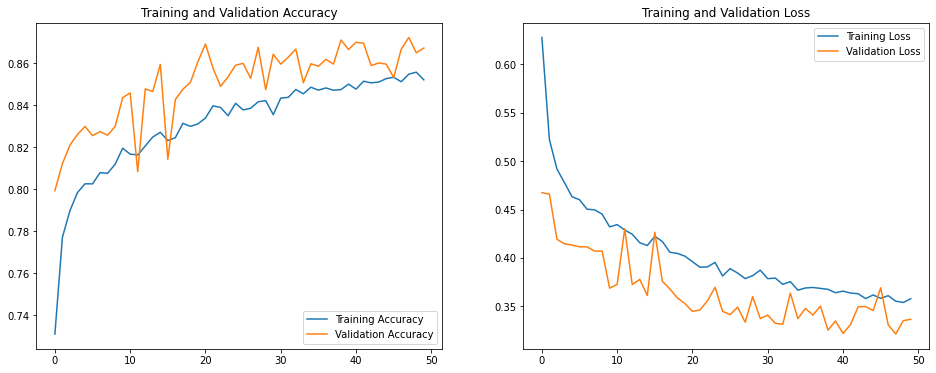

In [10]:
train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 39s 59ms/step - loss: 0.9471 - accuracy: 0.5879 - val_loss: 0.7486 - val_accuracy: 0.6728
Epoch 2/50
360/360 [==============================] - 16s 45ms/step - loss: 0.8087 - accuracy: 0.6435 - val_loss: 0.7023 - val_accuracy: 0.6952
Epoch 3/50
360/360 [==============================] - 16s 45ms/step - loss: 0.7786 - accuracy: 0.6550 - val_loss: 0.6831 - val_accuracy: 0.7056
Epoch 4/50
360/360 [==============================] - 16s 45ms/step - loss: 0.7613 - accuracy: 0.6624 - val_loss: 0.7160 - val_accuracy: 0.6719
Epoch 5/50
360/360 [==============================] - 16s 45ms/step - loss: 0.7426 - accuracy: 0.6768 - val_loss: 0.6519 - val_accuracy: 0.7074
Epoch 6/50
360/360 [==============================] - 16s 45ms/step - loss: 0.7258 -

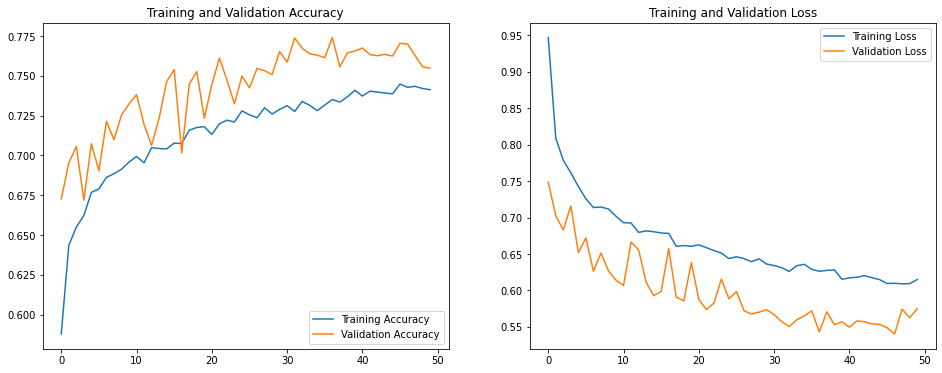

In [11]:
train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 37s 54ms/step - loss: 0.9476 - accuracy: 0.5880 - val_loss: 0.7261 - val_accuracy: 0.6768
Epoch 2/50
360/360 [==============================] - 16s 45ms/step - loss: 0.8164 - accuracy: 0.6364 - val_loss: 0.6773 - val_accuracy: 0.6999
Epoch 3/50
360/360 [==============================] - 16s 45ms/step - loss: 0.7762 - accuracy: 0.6576 - val_loss: 0.6789 - val_accuracy: 0.7016
Epoch 4/50
360/360 [==============================] - 16s 45ms/step - loss: 0.7526 - accuracy: 0.6706 - val_loss: 0.6522 - val_accuracy: 0.7103
Epoch 5/50
360/360 [==============================] - 16s 45ms/step - loss: 0.7400 - accuracy: 0.6736 - val_loss: 0.6648 - val_accuracy: 0.7048
Epoch 6/50
360/360 [==============================] - 16s 45ms/step - loss: 0.7323 - accuracy: 0.6768 - 

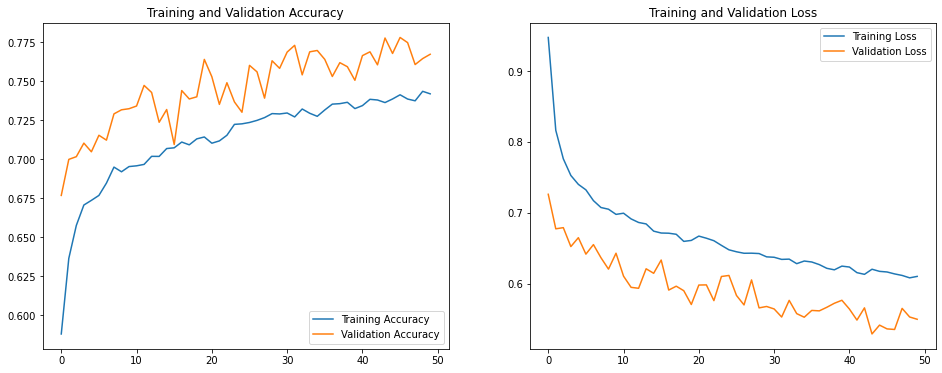

In [12]:
train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 36s 52ms/step - loss: 1.4805 - accuracy: 0.2786 - val_loss: 1.4255 - val_accuracy: 0.2860
Epoch 2/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4315 - accuracy: 0.2872 - val_loss: 1.4180 - val_accuracy: 0.2746
Epoch 3/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4291 - accuracy: 0.2834 - val_loss: 1.4204 - val_accuracy: 0.2890
Epoch 4/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4278 - accuracy: 0.2834 - val_loss: 1.4319 - val_accuracy: 0.2860
Epoch 5/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4259 - accuracy: 0.2908 - val_loss: 1.4277 - val_accuracy: 0.2890
Epoch 6/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4267 -

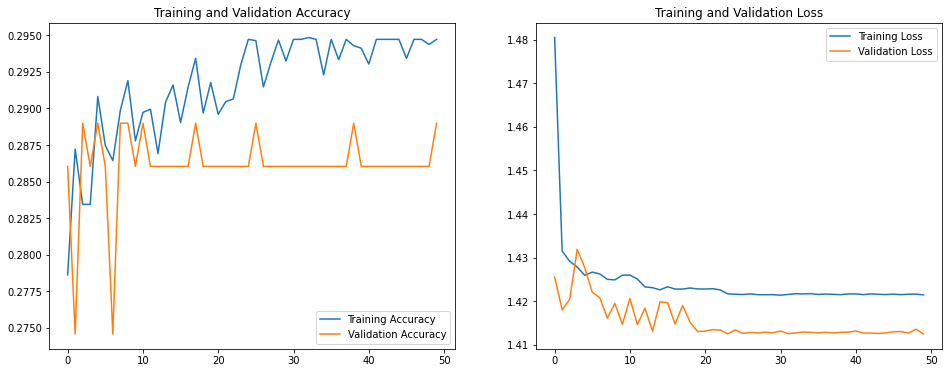

In [13]:
train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 37s 52ms/step - loss: 1.4811 - accuracy: 0.2804 - val_loss: 1.4218 - val_accuracy: 0.2746
Epoch 2/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4319 - accuracy: 0.2860 - val_loss: 1.4178 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4280 - accuracy: 0.2860 - val_loss: 1.4210 - val_accuracy: 0.2860
Epoch 4/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4277 - accuracy: 0.2850 - val_loss: 1.4180 - val_accuracy: 0.2860
Epoch 5/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4257 - accuracy: 0.2870 - val_loss: 1.4187 - val_accuracy: 0.2746
Epoch 6/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4264 - accuracy: 0.2845 - 

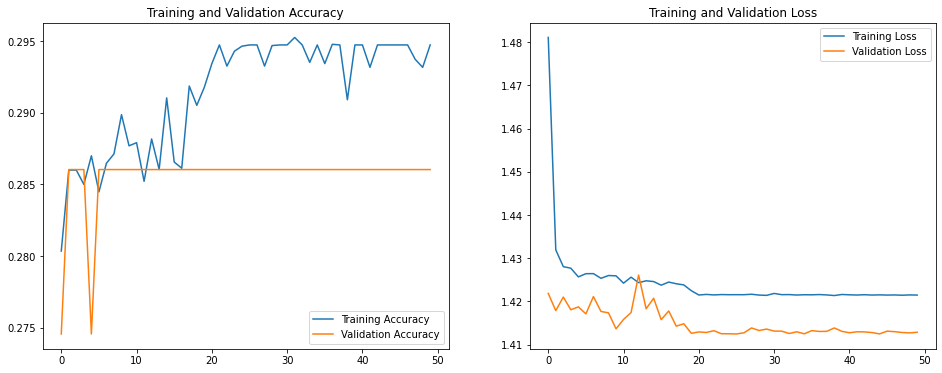

In [14]:
train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 36s 52ms/step - loss: 1.4849 - accuracy: 0.2791 - val_loss: 1.4164 - val_accuracy: 0.2860
Epoch 2/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4320 - accuracy: 0.2855 - val_loss: 1.4152 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 15s 43ms/step - loss: 1.4287 - accuracy: 0.2830 - val_loss: 1.4227 - val_accuracy: 0.2746
Epoch 4/50
360/360 [==============================] - 15s 42ms/step - loss: 1.4312 - accuracy: 0.2823 - val_loss: 1.4189 - val_accuracy: 0.2860
Epoch 5/50
360/360 [==============================] - 15s 42ms/step - loss: 1.4278 - accuracy: 0.2863 - val_loss: 1.4184 - val_accuracy: 0.2860
Epoch 6/50
360/360 [==============================] - 15s 43ms/step - loss: 1.4262 -

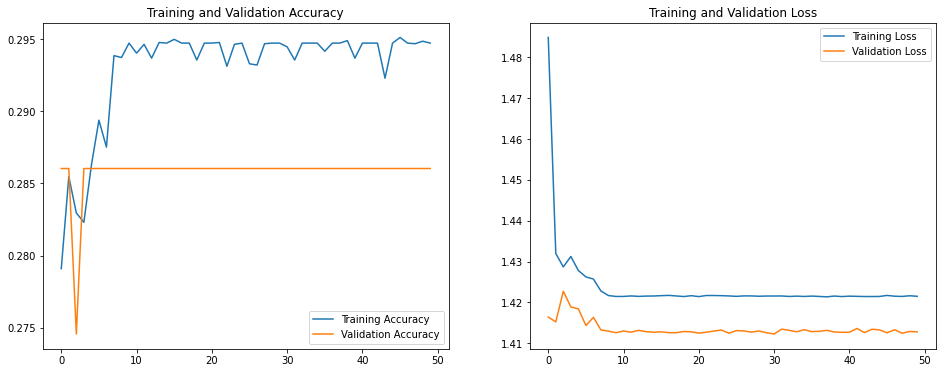

In [15]:
train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 36s 52ms/step - loss: 1.5203 - accuracy: 0.2781 - val_loss: 1.4232 - val_accuracy: 0.2860
Epoch 2/50
360/360 [==============================] - 15s 42ms/step - loss: 1.4319 - accuracy: 0.2831 - val_loss: 1.4144 - val_accuracy: 0.2890
Epoch 3/50
360/360 [==============================] - 15s 42ms/step - loss: 1.4306 - accuracy: 0.2837 - val_loss: 1.4203 - val_accuracy: 0.2746
Epoch 4/50
360/360 [==============================] - 15s 43ms/step - loss: 1.4293 - accuracy: 0.2858 - val_loss: 1.4273 - val_accuracy: 0.2746
Epoch 5/50
360/360 [==============================] - 15s 42ms/step - loss: 1.4279 - accuracy: 0.2900 - val_loss: 1.4135 - val_accuracy: 0.2860
Epoch 6/50
360/360 [==============================] - 15s 42ms/step - loss: 1.4265 - accuracy: 0.2945 - 

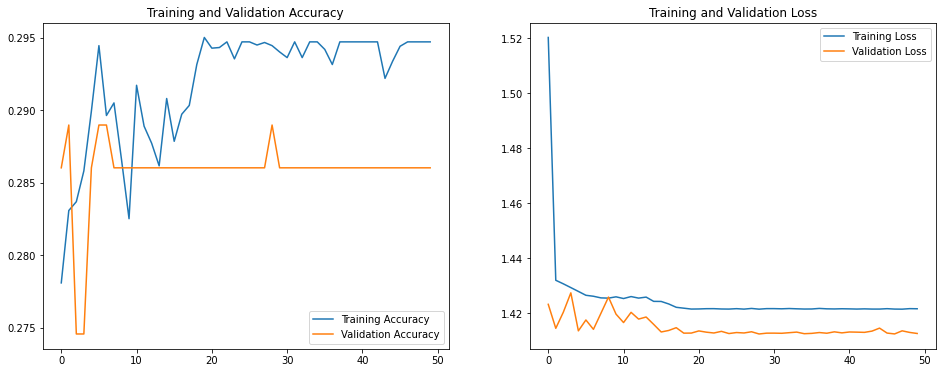

In [16]:
train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 36s 51ms/step - loss: 1.4928 - accuracy: 0.2827 - val_loss: 1.4192 - val_accuracy: 0.2860
Epoch 2/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4332 - accuracy: 0.2814 - val_loss: 1.4146 - val_accuracy: 0.2890
Epoch 3/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4341 - accuracy: 0.2845 - val_loss: 1.4217 - val_accuracy: 0.2860
Epoch 4/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4282 - accuracy: 0.2865 - val_loss: 1.4231 - val_accuracy: 0.2890
Epoch 5/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4276 - accuracy: 0.2880 - val_loss: 1.4153 - val_accuracy: 0.2860
Epoch 6/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4262 -

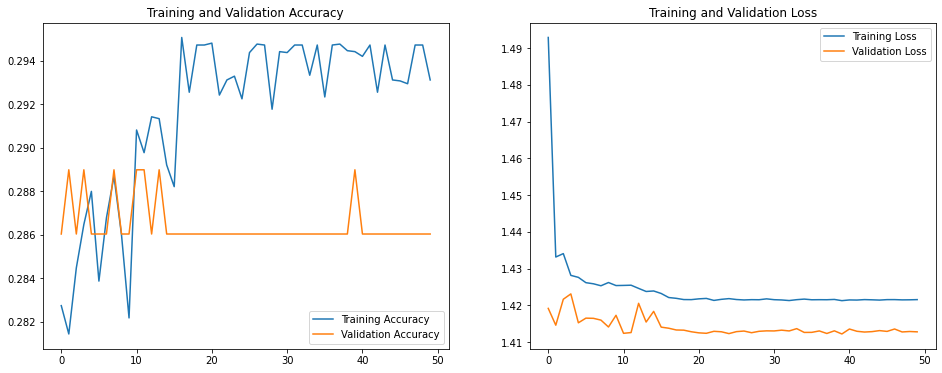

In [17]:
train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 36s 51ms/step - loss: 1.4855 - accuracy: 0.2886 - val_loss: 1.4171 - val_accuracy: 0.2890
Epoch 2/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4354 - accuracy: 0.2824 - val_loss: 1.4143 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4299 - accuracy: 0.2851 - val_loss: 1.4195 - val_accuracy: 0.2746
Epoch 4/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4290 - accuracy: 0.2838 - val_loss: 1.4209 - val_accuracy: 0.2860
Epoch 5/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4274 - accuracy: 0.2878 - val_loss: 1.4185 - val_accuracy: 0.2860
Epoch 6/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4293 - accuracy: 0.2825 - 

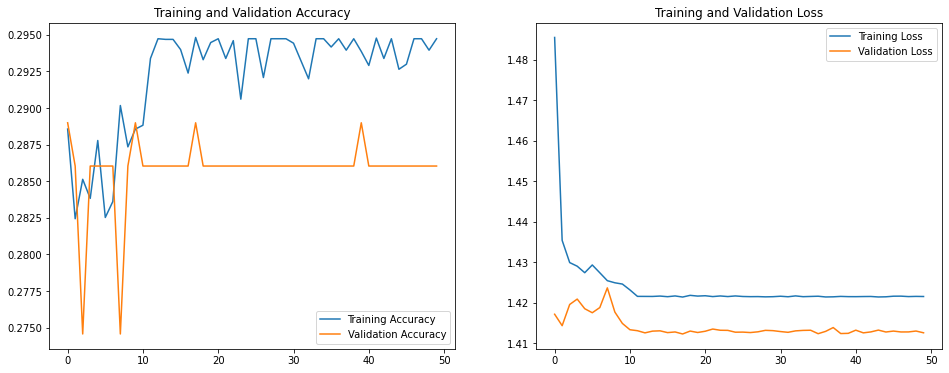

In [18]:
train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/50
360/360 [==============================] - 36s 51ms/step - loss: 1.4929 - accuracy: 0.2761 - val_loss: 1.4123 - val_accuracy: 0.2890
Epoch 2/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4334 - accuracy: 0.2843 - val_loss: 1.4198 - val_accuracy: 0.2860
Epoch 3/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4288 - accuracy: 0.2880 - val_loss: 1.4168 - val_accuracy: 0.2746
Epoch 4/50
360/360 [==============================] - 16s 44ms/step - loss: 1.4282 - accuracy: 0.2835 - val_loss: 1.4179 - val_accuracy: 0.2890
Epoch 5/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4266 - accuracy: 0.2858 - val_loss: 1.4146 - val_accuracy: 0.2860
Epoch 6/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4272 -

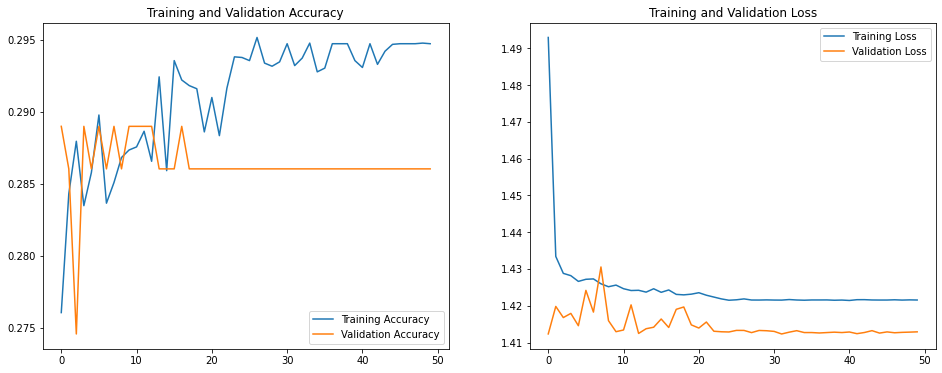

In [19]:
train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/50
360/360 [==============================] - 36s 51ms/step - loss: 1.4760 - accuracy: 0.2809 - val_loss: 1.4264 - val_accuracy: 0.2860
Epoch 2/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4324 - accuracy: 0.2869 - val_loss: 1.4414 - val_accuracy: 0.2890
Epoch 3/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4288 - accuracy: 0.2870 - val_loss: 1.4188 - val_accuracy: 0.2746
Epoch 4/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4273 - accuracy: 0.2837 - val_loss: 1.4276 - val_accuracy: 0.2890
Epoch 5/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4271 - accuracy: 0.2827 - val_loss: 1.4169 - val_accuracy: 0.2746
Epoch 6/50
360/360 [==============================] - 16s 43ms/step - loss: 1.4267 - accuracy: 0.2885 - 

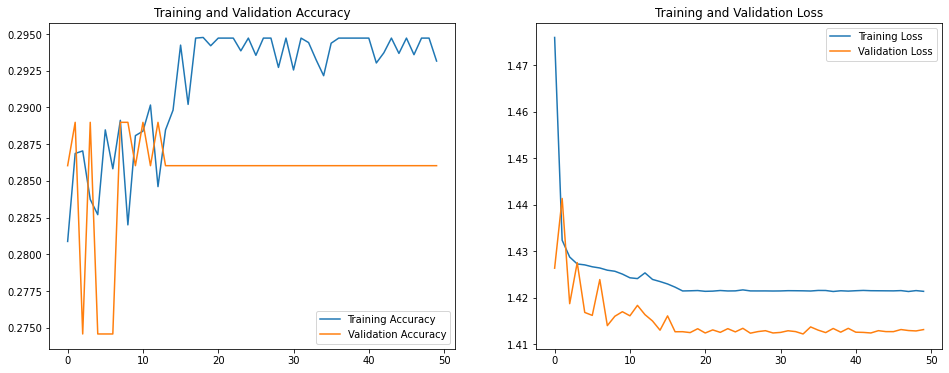

In [20]:
train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)